In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

Визуальный анализ ряда
- Стабилизация дисперсии (при необходимости)
- Выбор порядка дифференцирования
- Выбор начальных приближений для p, q, P, Qp,q,P,Q
- Обучение и сравнение моделей-кандидатов, выбор победителя
- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно - - - скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Qp,q,P,Q.
- Прогнозирование с помощью финальной модели.


In [10]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.columns = ['salary']
salary

,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


## Визуальный анализ ряда

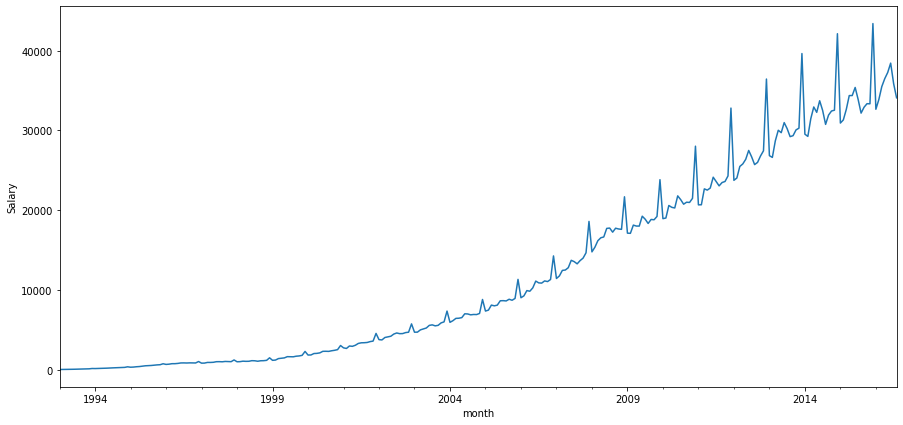

In [11]:
plt.figure(figsize(15,7))
salary.salary.plot()
plt.ylabel('Salary')
pylab.show()

Временной ряд имеет явный повышающийся тренд, сезонность и изменяющююся дисперсию.

Выполним формальную проверку на стационарность и выплним STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

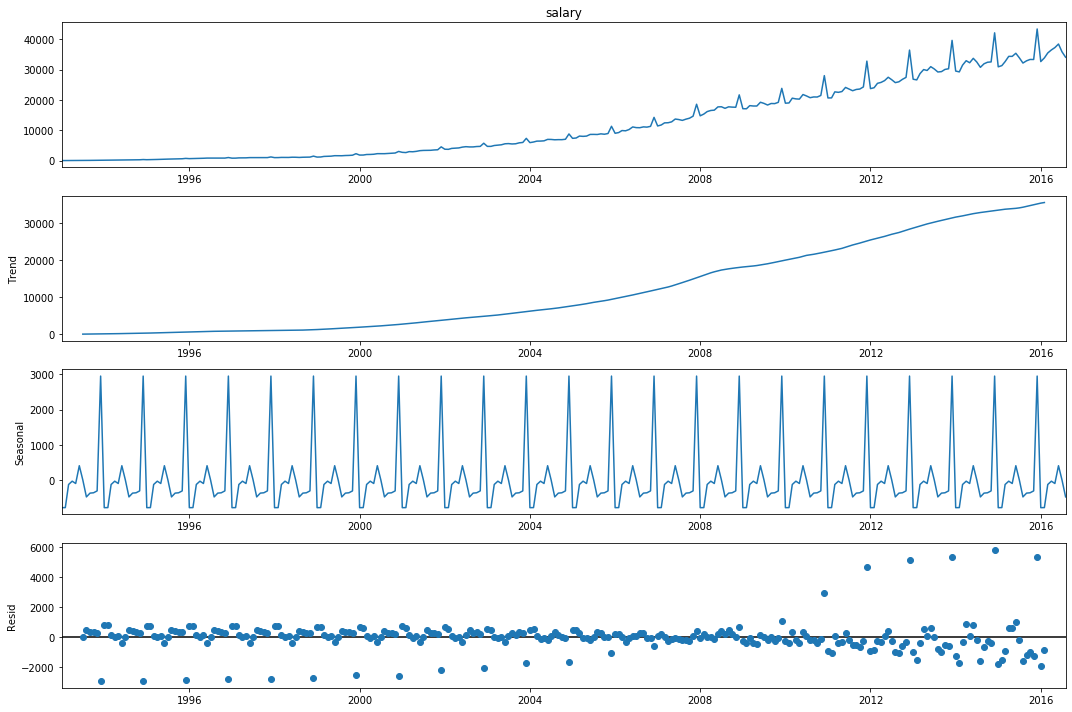

In [13]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary)[1])

## Стабилизация дисперсии
Выполним преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


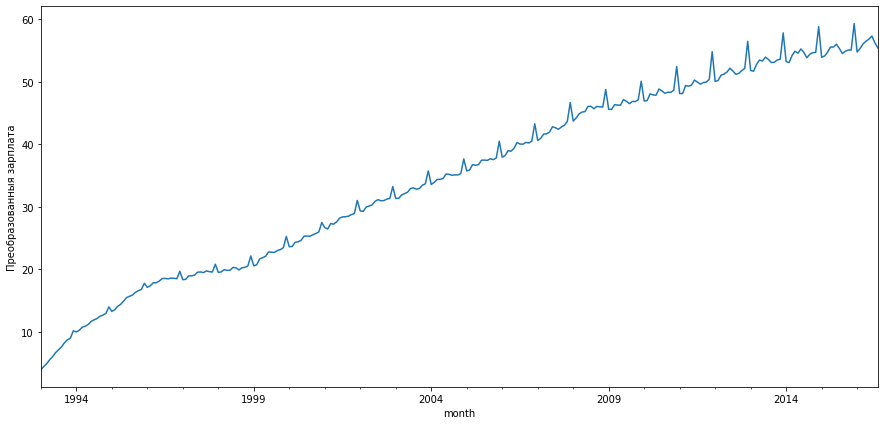

In [15]:
salary['salary_box'], lmbda = stats.boxcox(salary.salary)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel(u'Преобразованныя зарплата')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

Продолжим преобразовывать ряд в стационарный. Проведем сезонное дифференцирование.

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

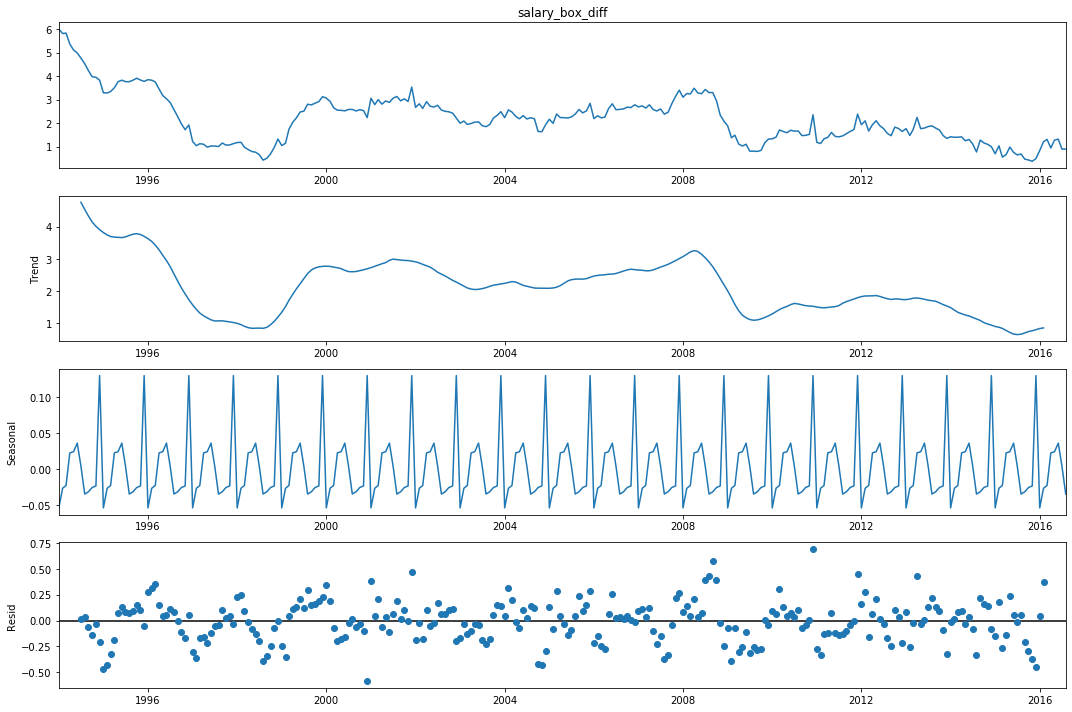

In [16]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

Хотя гипотеза нестационарности отвергается критерием Дики-Фуллера, тренд все еще есть. Выполним дифференцирование.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

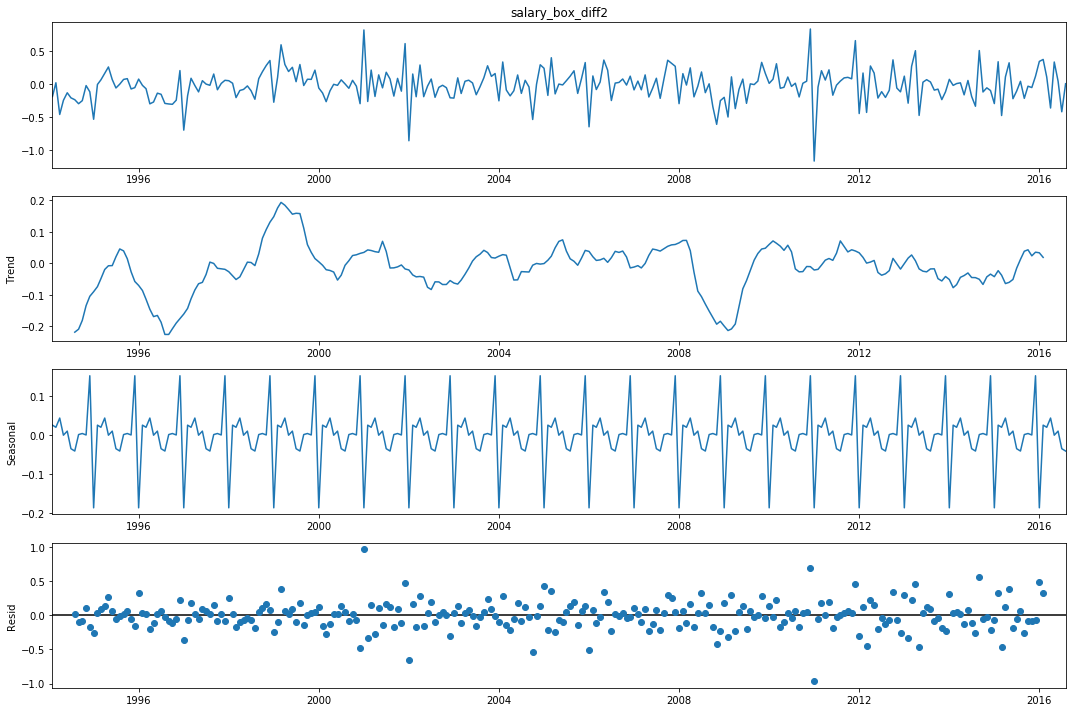

In [17]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

Гипотеза нестационарность уверенно отвергается критерием Дики-Фуллера. Таким образом, D=1, d=1.

Проверим, как выглядил бы финальный ряд при смене порядка диффиренцирования.

Критерий Дики-Фуллера: p=0.014396


<Figure size 1080x720 with 0 Axes>

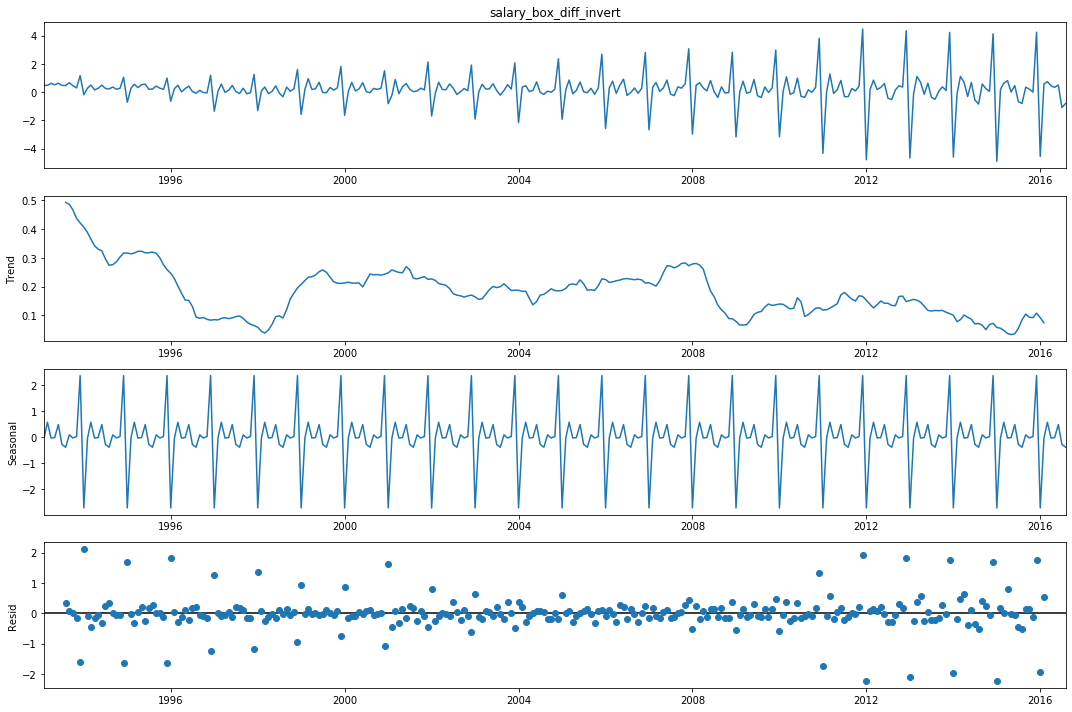

In [18]:
salary['salary_box_diff_invert'] = salary.salary_box - salary.salary_box.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff_invert[1:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff_invert[1:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

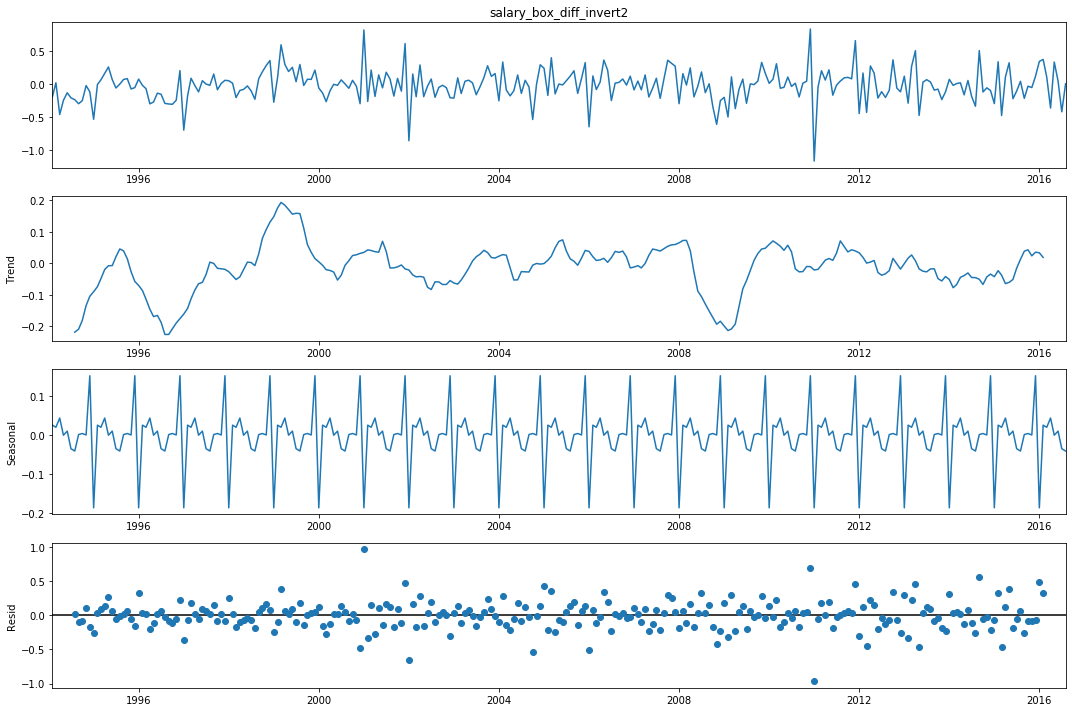

In [20]:
salary['salary_box_diff_invert2'] = salary.salary_box_diff_invert - salary.salary_box_diff_invert.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff_invert2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff_invert2[13:])[1])

Как видим от порядка диффиренцирования в данной задачи итоговый результат не меняется. Таким образом, параметры (D,d)=(1,1) в модели SARIMA(p,d,q)x(P,D,Q)

## Выбор начальных приближений для p, q, P, Q
Посмотрим на ACF и PACF полученного ряда:

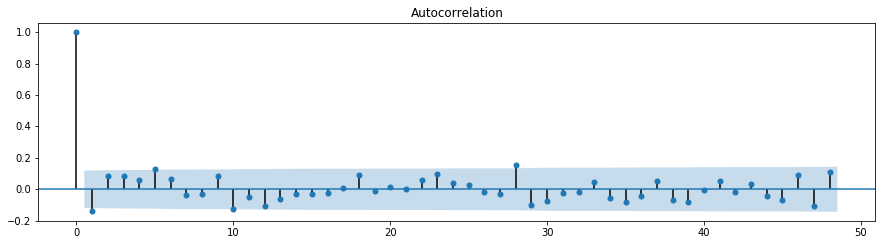

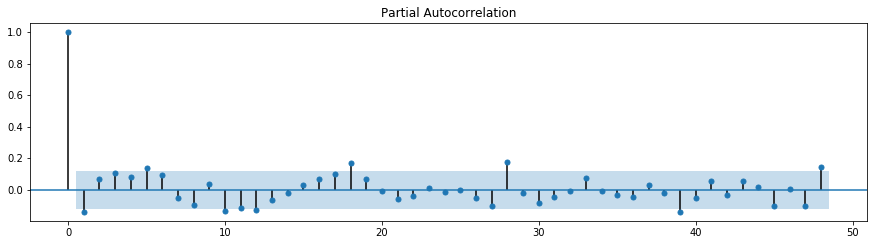

In [21]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0(последний значинимы сезонный лаг / 12), q=5(последни значиммый не сезонный лаг, но не сильно большой), по частичной автокоррекции подбираем P=1(последний значинимы сезонный лаг / 12), p=5(последни значиммый не сезонный лаг, но не сильно большой)

In [22]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

## Обучение и сравнение моделей-кандидатов, выбор победителя

In [23]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 3min 32s


In [26]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
142  (5, 5, 1, 0) -25.090430
141  (5, 5, 0, 1) -24.672096
143  (5, 5, 1, 1) -24.068700
118  (4, 5, 1, 0) -23.862231
117  (4, 5, 0, 1) -23.553023


Минимальный AIC мы получаем для модели с параметрами (5,5,1,0). Модели с более маленькими коофициентами имеют существенную разницу в AIC, как лучшую модель берем именно ее.

In [27]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood                  24.545
Date:                             Mon, 27 Apr 2020   AIC                            -25.090
Time:                                     12:38:23   BIC                             18.135
Sample:                                 01-01-1993   HQIC                            -7.735
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2200      0.594     -0.371      0.711      -1.384       0.944
ar.L2          0.2427      

## Анализ остатков построенной модели

Критерий Стьюдента: p=0.162261
Критерий Дики-Фуллера: p=0.000000


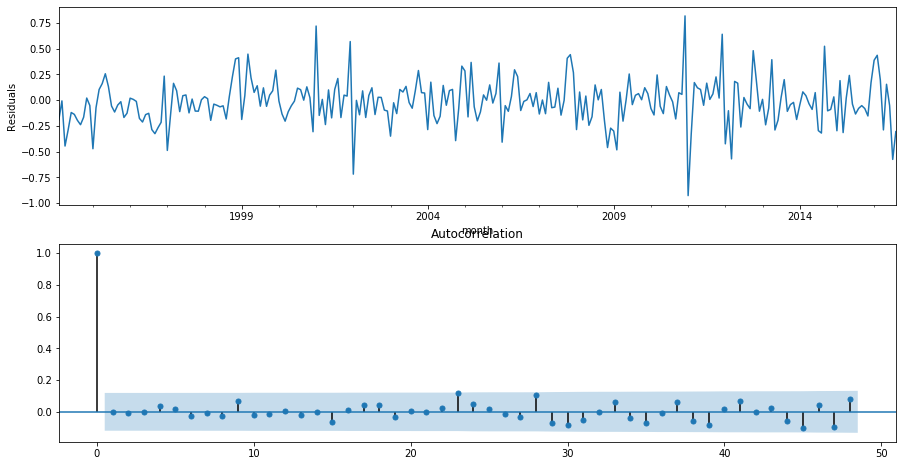

In [28]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

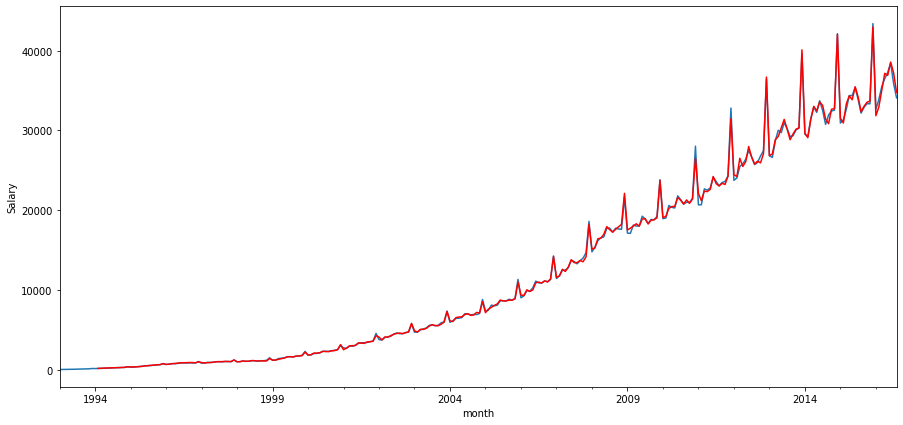

In [29]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.salary.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

Визуально модель описывает данные хорошо.

## Прогнозирование с помощью финальной модели на 2 года вперед

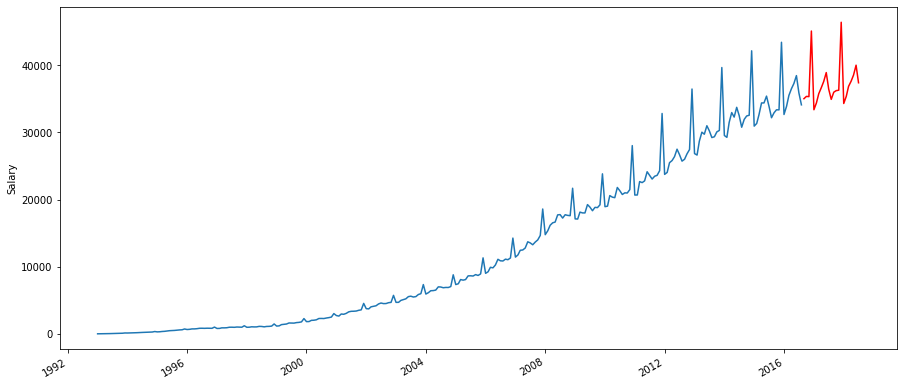

In [32]:
salary2 = salary[['salary']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=284+24), lmbda)

plt.figure(figsize(15,7))
salary2.salary.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

Визуально модель делает достаточно хороший прогноз.